<a href="https://colab.research.google.com/github/tigju/DS-Unit-1-Sprint-3-Linear-Algebra/blob/master/module4-clustering/LS_DS_134_Clustering_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering

# 1) Use the "Breast Cancer Wisconsin (Diagnostic) Data Set" from Kaggle to try and cluster types of cancer cells. 

Here's the original dataset for your reference:

<https://www.kaggle.com/uciml/breast-cancer-wisconsin-data>

## This is a supervised learning dataset

(Because it has **labels** - The "diagnosis" column.)

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this
from sklearn.preprocessing import StandardScaler # You don't necessarily have to use this

df_1 = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")
print(df_1.shape)
df_1.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Now it's an unsupervised learning dataset

(Because we've removed the diagnosis label) - Use this version.

In [0]:
df_2 = df_1.drop('diagnosis', axis=1)
df_2.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [0]:
df_2.isnull().sum()

id                           0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed: 32                569
dtype: i

In [0]:
df_2 = df_2.drop('Unnamed: 32', axis=1)

## Let's do it!

- You might want to do some data exploration to see if you can find specific columns that will help you find distinct clusters of cells
- You might want to use the elbow method to decide on the number of clusters to use.


In [0]:
features_1 = ['area_mean', 'concave points_worst']

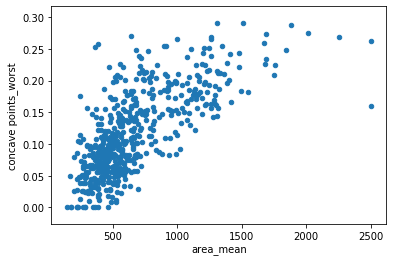

In [0]:
df_2[features_1].plot(kind="scatter", x=features_1[0], y=features_1[1]);

In [0]:
model = KMeans(n_clusters=2, max_iter=1)

In [0]:
model.fit(df_2[features_1].values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
df_2['cluster'] = model.labels_

In [0]:
centroids = model.cluster_centers_

In [0]:
cc_1 = pd.DataFrame(centroids)
cc_1.head()

,0,1
0,503.785556,0.094003
1,1226.289076,0.192519


In [0]:
base_colors_1  =  ['r', 'g']
colors_1 = [base_colors_1[centroid] for centroid in model.labels_]

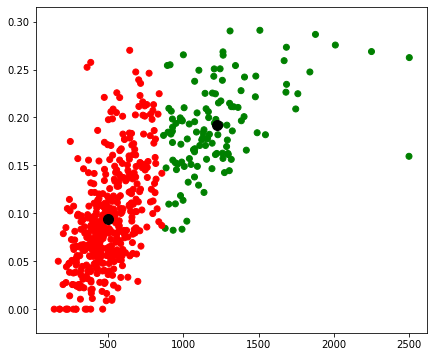

In [0]:
fig, ax =  plt.subplots(figsize=(7,6))
ax.scatter(df_2[features_1[0]], df_2[features_1[1]], c=colors_1)
ax.scatter(cc_1[0], cc_1[1], c='k', s=100);

In [0]:
from sklearn import metrics
metrics.silhouette_score(df_2, model.labels_, metric='euclidean')

0.2732931738630352

In [0]:
cluster_labels = model.labels_
cluster_labels

array([1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

## Check you work: 

This is something that in a truly unsupervised learning situation **WOULD NOT BE POSSIBLE**. But for educational purposes go back and grab the true diagnosis column (label) from the original dataset. Take your cluster labels and compare them to the original diagnosis column. You can make scatterplots for each to see how they compare or you can calculate a percent accuracy score like: 
\begin{align}
\frac{\text{Num Correct Labels}}{\text{Num Total Observations}}
\end{align}

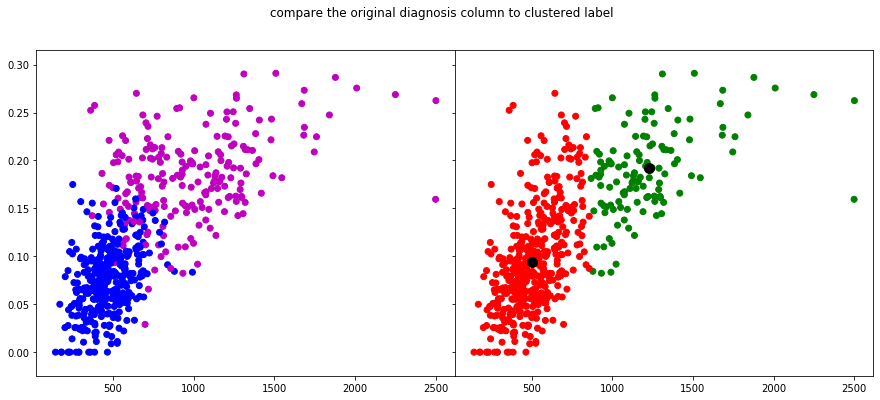

In [0]:
fig, (ax1,ax2) =  plt.subplots(1,2, sharex='col', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0}, figsize=(15,6))
fig.suptitle('compare the original diagnosis column to clustered label')
ax1.scatter(x=df_1['area_mean'], y=df_1['concave points_worst'], c=df_1['diagnosis']);
ax2.scatter(df_2[features_1[0]], df_2[features_1[1]], c=colors_1)
ax2.scatter(cc_1[0], cc_1[1], c='black', s=100);

# 2) Perform PCA on your dataset first and *then* use k-means clustering. 

- You need to standardize your data before PCA.
- First try clustering just on PC1 and PC2 so that you can make a scatterplot of your clustering.
- Then use use a scree plot to decide how many principal components to include in your clustering, and use however many principal components you need in order to retain 90% of the variation of the original dataset



In [0]:
##### Your Code Here #####
df2_copy = df_2.drop('cluster', axis=1)

In [0]:
features_2=list(df2_copy.columns)
features_2

['id',
 'radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'symmetry_worst',
 'fractal_dimension_worst']

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [0]:
scaled_data = scaler.fit_transform(df2_copy)

In [0]:
scaled_data[:5]

array([[-2.36405166e-01,  1.09706398e+00, -2.07333501e+00,
         1.26993369e+00,  9.84374905e-01,  1.56846633e+00,
         3.28351467e+00,  2.65287398e+00,  2.53247522e+00,
         2.21751501e+00,  2.25574689e+00,  2.48973393e+00,
        -5.65265059e-01,  2.83303087e+00,  2.48757756e+00,
        -2.14001647e-01,  1.31686157e+00,  7.24026158e-01,
         6.60819941e-01,  1.14875667e+00,  9.07083081e-01,
         1.88668963e+00, -1.35929347e+00,  2.30360062e+00,
         2.00123749e+00,  1.30768627e+00,  2.61666502e+00,
         2.10952635e+00,  2.29607613e+00,  2.75062224e+00,
         1.93701461e+00],
       [-2.36403445e-01,  1.82982061e+00, -3.53632408e-01,
         1.68595471e+00,  1.90870825e+00, -8.26962447e-01,
        -4.87071673e-01, -2.38458552e-02,  5.48144156e-01,
         1.39236330e-03, -8.68652457e-01,  4.99254601e-01,
        -8.76243603e-01,  2.63326966e-01,  7.42401948e-01,
        -6.05350847e-01, -6.92926270e-01, -4.40780058e-01,
         2.60162067e-01, -8.05

In [0]:
df_scaled = pd.DataFrame(scaled_data,columns=features_2)
df_scaled.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,-0.236405,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,2.489734,-0.565265,2.833031,2.487578,-0.214002,1.316862,0.724026,0.660820,1.148757,0.907083,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,-0.236403,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,0.499255,-0.876244,0.263327,0.742402,-0.605351,-0.692926,-0.440780,0.260162,-0.805450,-0.099444,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,0.431741,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,1.228676,-0.780083,0.850928,1.181336,-0.297005,0.814974,0.213076,1.424827,0.237036,0.293559,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,0.432121,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,0.326373,-0.110409,0.286593,-0.288378,0.689702,2.744280,0.819518,1.115007,4.732680,2.047511,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,0.432201,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,1.270543,-0.790244,1.273189,1.190357,1.483067,-0.048520,0.828471,1.144205,-0.361092,0.499328,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


In [0]:
df_scaled.mean()

id                         8.877882e-18
radius_mean               -1.256562e-16
texture_mean               1.049736e-16
perimeter_mean            -1.272171e-16
area_mean                 -1.900452e-16
smoothness_mean            1.490704e-16
compactness_mean           2.544342e-16
concavity_mean            -1.338511e-16
concave points_mean       -8.429110e-17
symmetry_mean              2.081912e-16
fractal_dimension_mean     5.408679e-16
radius_se                  2.475807e-16
texture_se                -9.912009e-17
perimeter_se              -2.968237e-16
area_se                   -1.088760e-16
smoothness_se              4.426014e-16
compactness_se             1.958988e-16
concavity_se               1.678017e-16
concave points_se          2.185325e-17
symmetry_se                1.523874e-16
fractal_dimension_se      -5.658430e-17
radius_worst              -7.988142e-16
texture_worst             -1.834112e-17
perimeter_worst           -4.015534e-16
area_worst                -2.848727e-17


In [0]:
df_scaled[features_2].std()

id                         1.00088
radius_mean                1.00088
texture_mean               1.00088
perimeter_mean             1.00088
area_mean                  1.00088
smoothness_mean            1.00088
compactness_mean           1.00088
concavity_mean             1.00088
concave points_mean        1.00088
symmetry_mean              1.00088
fractal_dimension_mean     1.00088
radius_se                  1.00088
texture_se                 1.00088
perimeter_se               1.00088
area_se                    1.00088
smoothness_se              1.00088
compactness_se             1.00088
concavity_se               1.00088
concave points_se          1.00088
symmetry_se                1.00088
fractal_dimension_se       1.00088
radius_worst               1.00088
texture_worst              1.00088
perimeter_worst            1.00088
area_worst                 1.00088
smoothness_worst           1.00088
compactness_worst          1.00088
concavity_worst            1.00088
concave points_worst

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [0]:
pca_features = pca.fit_transform(df_scaled)
pca_features[:5]

array([[ 9.18319983,  1.97127137],
       [ 2.38329766, -3.75345877],
       [ 5.74247239, -1.08035048],
       [ 7.12438398, 10.27222513],
       [ 3.94569386, -1.95968949]])

In [0]:
sum(pca.explained_variance_ratio_)

0.6124149284660225

In [0]:
1-sum(pca.explained_variance_ratio_)

0.3875850715339775

In [0]:
df_pca=pd.DataFrame(pca_features, columns=['comp_1', 'comp_2'])
df_pca.head()

,comp_1,comp_2
0,9.183200,1.971271
1,2.383298,-3.753459
2,5.742472,-1.080350
3,7.124384,10.272225
4,3.945694,-1.959689


In [0]:
model = KMeans(n_clusters=2, max_iter=1)

In [0]:
model.fit(df_pca.values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
df_pca['cluster'] = model.labels_

In [0]:
centroids_2   =  model.cluster_centers_

In [0]:
cc_2  =  pd.DataFrame(centroids_2)
cc_2.head()

,0,1
0,-2.236909,-0.029734
1,4.290278,0.057028


In [0]:
base_colors_2  =  ['r', 'g']
colors_2       =  [base_colors_2[centroid] for centroid in model.labels_]

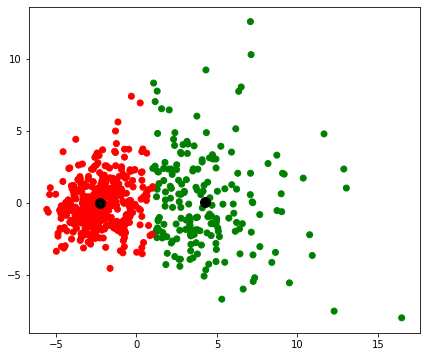

In [0]:
fig, ax =  plt.subplots(figsize=(7,6))
ax.scatter(df_pca['comp_1'], df_pca['comp_2'], c=colors_2)
ax.scatter(cc_2[0], cc_2[1], c='black', s=100);

In [0]:
metrics.silhouette_score(df2_copy, model.labels_, metric='euclidean')

0.1012766170709239

In [0]:
model.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

## Check your work: 

- Compare your PC1, PC2 clustering scatterplot to the clustering scatterplots you made on the raw data
- Calculate accuracy scores for both the PC1,PC2 Principal component clustering and the 90% of explained variance clustering.

How do your accuracy scores -when preprocessing the data with PCA- compare to the accuracy when simply clustering on the raw data?

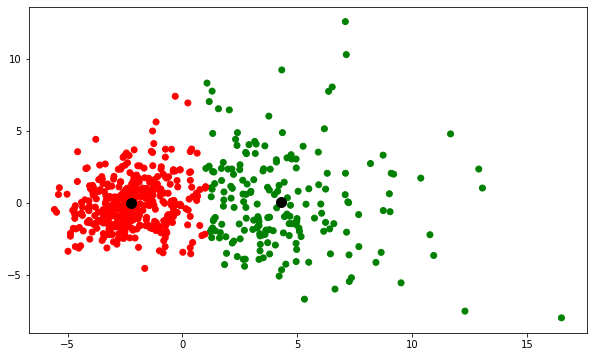

In [0]:
fig, ax1 =  plt.subplots(figsize=(10,6))

ax1.scatter(df_pca['comp_1'], df_pca['comp_2'], c=colors_2);
ax1.scatter(cc_2[0], cc_2[1], c='black', s=100)

plt.show()


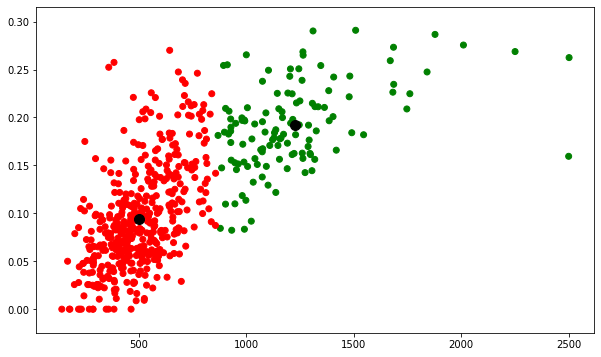

In [0]:
fig, ax2 =  plt.subplots(figsize=(10,6))
ax2.scatter(df_2[features_1[0]], df_2[features_1[1]], c=colors_1)
ax2.scatter(cc_1[0], cc_1[1], c='k', s=100);


# Stretch Goals:

- Study for the Sprint Challenge
- Work on your Data Storytelling Project